In [1]:
%load_ext autoreload
%autoreload 2

# 2. Results - обучение, сравнение моделей и визуализация


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader

from src.data_loader import TimeSeriesDS
from src.model import HybridForecaster
from src.config import WINDOW_SIZE, DEVICE, HIDDEN_SIZE, NUM_LAYERS
from metrics import summary_metrics

In [3]:
df = pd.read_csv('../data/features.csv').dropna().reset_index(drop=True)
df

,timestamp,y,lag_1,lag_24,lag_48,rolling_24,hour,dayofweek
0,2025-01-03 00:00:00,100.988897,98.487486,96.923294,97.750281,102.767898,0,4
1,2025-01-03 01:00:00,98.823438,100.988897,101.862905,103.011182,102.641254,1,4
2,2025-01-03 02:00:00,109.400875,98.823438,114.093370,111.496654,102.445733,2,4
3,2025-01-03 03:00:00,122.134689,109.400875,117.095877,109.504332,102.655683,3,4
4,2025-01-03 04:00:00,123.617520,122.134689,111.987860,107.548266,103.140253,4,4
...,...,...,...,...,...,...,...,...
2107,2025-03-31 19:00:00,190.461044,179.717631,188.639620,188.334340,205.301337,19,0
2108,2025-03-31 20:00:00,194.136139,190.461044,189.870065,183.591231,205.479090,20,0
2109,2025-03-31 21:00:00,199.543900,194.136139,189.704470,184.932982,205.889067,21,0
2110,2025-03-31 22:00:00,202.199959,199.543900,202.422869,195.663364,205.879779,22,0


In [5]:
y = df['y'].values.astype('float32').reshape(-1, 1)
X = df.drop(['timestamp', 'y'], axis=1).values.astype('float32')

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

ds = TimeSeriesDS(X_scaled, y_scaled, window=WINDOW_SIZE)
loader = DataLoader(ds, batch_size=256, shuffle=False)

input_dim = X.shape[1]
model = HybridForecaster(input_dim=input_dim, hidden_dim=HIDDEN_SIZE, n_layers=NUM_LAYERS).to(DEVICE)
model.load_state_dict(torch.load("../model_final.pt", map_location=DEVICE))
model.eval()

HybridForecaster(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc_neural): Linear(in_features=64, out_features=1, bias=True)
  (trend_model): Linear(in_features=6, out_features=1, bias=True)
)

## Получение предсказаний и обратное масштабирование

In [6]:
preds_scaled = []
trues_scaled = []

with torch.no_grad():
    for x, y_true in loader:
        x = x.to(DEVICE)
        out = model(x)
        preds_scaled.append(out.cpu().numpy())
        trues_scaled.append(y_true.numpy())

preds_scaled = np.concatenate(preds_scaled).reshape(-1, 1)
trues_scaled = np.concatenate(trues_scaled).reshape(-1, 1)

preds = scaler_y.inverse_transform(preds_scaled).flatten()
trues = scaler_y.inverse_transform(trues_scaled).flatten()

metrics = summary_metrics(trues, preds)

print("\n--- Итоговые метрики ---")
for k, v in metrics.items():
    print(f"{k:6}: {v:.4f}")


--- Итоговые метрики ---
MAE   : 7.1408
RMSE  : 17.4968
R2    : 0.7883
MAPE  : 4.0644


## Визуализация

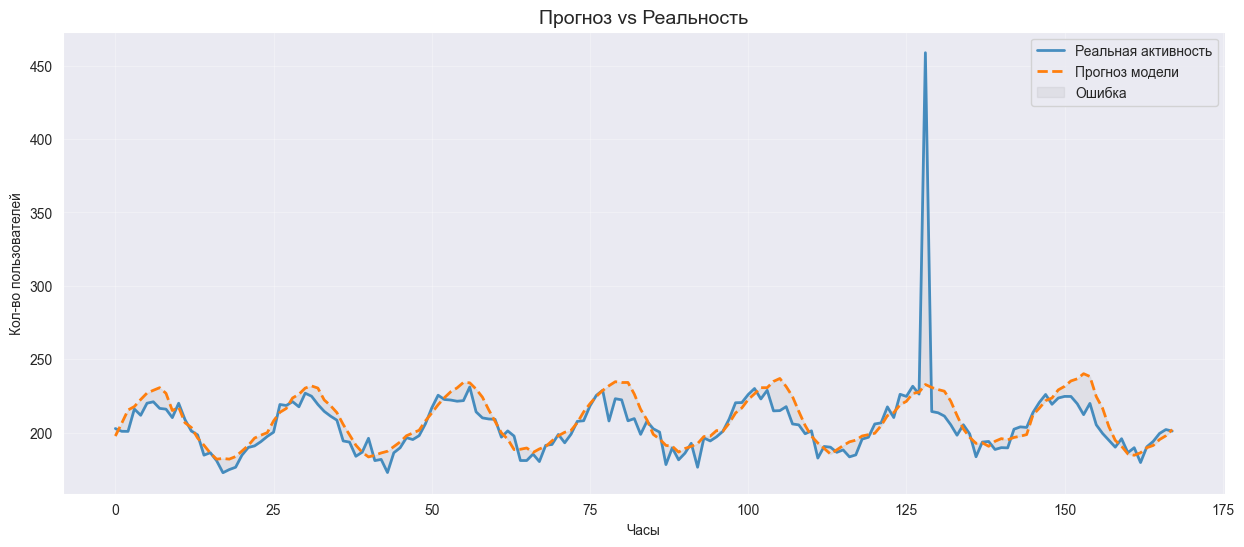

In [9]:
plt.figure(figsize=(15, 6))

view_limit = 168
plt.plot(trues[-view_limit:], label='Реальная активность', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(preds[-view_limit:], label='Прогноз модели', color='#ff7f0e', linestyle='--', linewidth=2)

plt.fill_between(range(view_limit), trues[-view_limit:], preds[-view_limit:], color='gray', alpha=0.1, label='Ошибка')

plt.title('Прогноз vs Реальность', fontsize=14)
plt.ylabel('Кол-во пользователей')
plt.xlabel('Часы')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Анализ ошибок

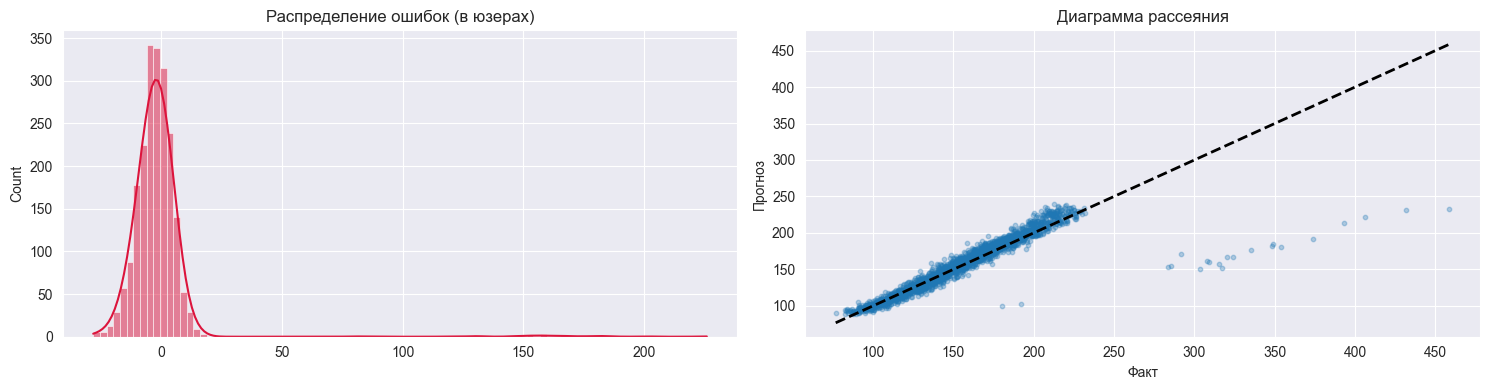

In [11]:
errors = trues - preds

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True, color='crimson')
plt.title('Распределение ошибок (в юзерах)')

plt.subplot(1, 2, 2)
plt.scatter(trues, preds, alpha=0.3, s=10)
plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'k--', lw=2)
plt.xlabel('Факт')
plt.ylabel('Прогноз')
plt.title('Диаграмма рассеяния')

plt.tight_layout()
plt.show()